In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = tf.constant([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [3]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype='int32')

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return tf.constant(co_matrix, dtype='int32')

In [4]:
def cos_similarity(x, y, eps=1e-8):
    x_f = tf.dtypes.cast(x, dtype='float')
    y_f = tf.dtypes.cast(y, dtype='float')
    nx = x_f / tf.math.sqrt(tf.math.reduce_sum(x_f**2) + eps)
    ny = y_f / tf.math.sqrt(tf.math.reduce_sum(y_f**2) + eps)
    return tf.tensordot(nx, ny, axes=1).numpy()

In [6]:
text = 'you say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0, c1))

0.70710677


In [7]:
C

<tf.Tensor: id=329, shape=(7, 7), dtype=int32, numpy=
array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)>

In [8]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('%s is no found' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = tf.slice(word_matrix, [query_id, 0], [1, 7]).numpy()[0]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(tf.slice(word_matrix, [i, 0], [1, 7]).numpy()[0], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [9]:
most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067690849304
 i: 0.7071067690849304
 hello: 0.7071067690849304
 say: 0.0
 and: 0.0


In [10]:
def ppmi(C, verbose=False, eps=1e-8):
    C = tf.dtypes.cast(C, dtype='float')
    M = np.zeros_like(C.numpy(), dtype='float')
    N = tf.dtypes.cast(tf.math.reduce_sum(C), dtype='float')
    S = tf.dtypes.cast((tf.math.reduce_sum(C, axis=0)), dtype='float')

    pmi = tf.math.log(N * C / (tf.tensordot(S, S, axes=0) + eps) + eps) / np.log(2)
    
    return tf.dtypes.cast(tf.greater(pmi, 0), dtype='float') * pmi + M #-0 -> 0

In [11]:
W = ppmi(C)

In [12]:
s = tf.linalg.svd(W)[0].numpy()
u = tf.linalg.svd(W)[1].numpy()
v = tf.linalg.svd(W)[2].numpy()

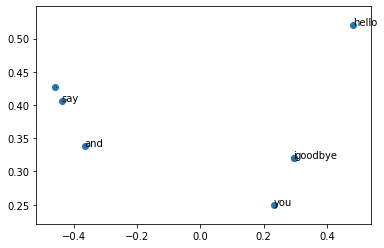

In [13]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (u[word_id, 0], u[word_id, 1]))
    
plt.scatter(u[:,0], u[:, 1])
plt.show()

In [14]:
import sys
sys.path.append('..')
from dataset import ptb

In [29]:
window_size = 3
wordvec_size = 100
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

In [30]:
print('counting co-occurrence...')
C = create_co_matrix(corpus, vocab_size, window_size)

counting co-occurrence...


In [31]:
print('calculating PPMI...')
W = ppmi(C)

calculating PPMI...


In [19]:
import time

In [32]:
start = time.time()
svd = tf.linalg.svd(W)
s = svd[0].numpy()
u = svd[1].numpy()
v = svd[2].numpy()
print(time.time() - start)

260.2724175453186


In [33]:
word_vecs = tf.slice(svd[1], [0, 0], [u.shape[0],wordvec_size])

In [34]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=20)


[query] you
 're: 0.9783572554588318
 we: 0.9766966700553894
 'm: 0.9672219157218933
 people: 0.9615544676780701
 really: 0.9541482329368591
 your: 0.9533817768096924
 what: 0.9526839852333069
 do: 0.95204097032547
 always: 0.9488503932952881
 going: 0.9474961757659912
 think: 0.9472580552101135
 i: 0.9419209957122803
 too: 0.9415355920791626
 something: 0.93734210729599
 so: 0.9340291023254395
 how: 0.9336977601051331
 've: 0.9328427910804749
 get: 0.9293616414070129
 seems: 0.9282641410827637
 'll: 0.9280436038970947

[query] year
 months: 0.967208981513977
 yesterday: 0.9511715769767761
 trading: 0.9466967582702637
 earlier: 0.9463159441947937
 since: 0.9362529516220093
 friday: 0.9348338842391968
 N: 0.9304744005203247
 oct.: 0.9275843501091003
 close: 0.9274879097938538
 early: 0.9273102283477783
 during: 0.9259999990463257
 nearly: 0.9208763837814331
 day: 0.9190447330474854
 stock: 0.913546085357666
 second: 0.9128015041351318
 monday: 0.9091829061508179
 down: 0.90913355350494